In [41]:
import pandas as pd
import numpy as np
import tensorflow as tf

from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import LSTM, Input, Dropout, Dense, RepeatVector
from sklearn import metrics

from matplotlib import pyplot as plt
import seaborn as sns

In [2]:
data = pd.read_csv('./dataset/inflearn_creditcard.csv')
data.head()

,Time,V1,V2,V3,V4,V5,V6,V7,V8,V9,...,V21,V22,V23,V24,V25,V26,V27,V28,Amount,Class
0,0:00:00,-1.359807,-0.072781,2.536347,1.378155,-0.338321,0.462388,0.239599,0.098698,0.363787,...,-0.018307,0.277838,-0.110474,0.066928,0.128539,-0.189115,0.133558,-0.021053,5.008105,0
1,0:00:00,1.191857,0.266151,0.166480,0.448154,0.060018,-0.082361,-0.078803,0.085102,-0.255425,...,-0.225775,-0.638672,0.101288,-0.339846,0.167170,0.125895,-0.008983,0.014724,0.989913,0
2,0:00:24,-1.358354,-1.340163,1.773209,0.379780,-0.503198,1.800499,0.791461,0.247676,-1.514654,...,0.247998,0.771679,0.909412,-0.689281,-0.327642,-0.139097,-0.055353,-0.059752,5.936641,0
3,0:00:24,-0.966272,-0.185226,1.792993,-0.863291,-0.010309,1.247203,0.237609,0.377436,-1.387024,...,-0.108300,0.005274,-0.190321,-1.175575,0.647376,-0.221929,0.062723,0.061458,4.816249,0
4,0:00:48,-1.158233,0.877737,1.548718,0.403034,-0.407193,0.095921,0.592941,-0.270533,0.817739,...,-0.009431,0.798278,-0.137458,0.141267,-0.206010,0.502292,0.219422,0.215153,4.248367,0


In [3]:
df = data.copy()

In [4]:
from collections import Counter
LABELS = ['0', '1']
Counter(df['Class'])

Counter({0: 283253, 1: 473})

In [5]:
# # 정상 데이터 시각화
### neg = df[df['Class']==0]
# neg.plot()

In [6]:
# # 사기 데이터 시각화
### pos = df[df['Class']==0]
# pos.plot(legend=False)

# 데이터, 라벨 분리

In [7]:
features = df.drop(['Time','Class'], axis=1).values
labels = np.array(df.pop('Class'))

In [8]:
n_features = features.shape[1] # 29

# 시퀀스 data 생성

In [9]:
# 모델에서 사용하기 위해 생성된 훈련 시퀀스
def temporalize(X, y, timesteps):
    output_X = []
    output_y = []
    for i in range(len(X) - timesteps - 1):
        t = []
        for j in range(1, timesteps + 1):
            # Gather the past records upto the lookback period
            t.append(X[[(i + j + 1)], :])
        output_X.append(t)
        output_y.append(y[i + timesteps + 1])
    return np.squeeze(np.array(output_X)), np.array(output_y)

In [10]:
timesteps = 30

# Temporalize
x, y = temporalize(features, labels, timesteps)
print(x.shape) # (283695, 30, 29)

(283695, 30, 29)


# Train, Test 분리

In [11]:
from sklearn.model_selection import train_test_split

In [15]:
x_train, x_test, y_train, y_test = train_test_split(x, y, test_size=0.5)
x_train, x_valid, y_train, y_valid = train_test_split(x_train, y_train, test_size=0.5)

print(len(x_train))  # 70923
print(len(x_valid))  # 70924
print(len(x_test))   # 141848

70923
70924
141848


In [16]:
# For training the autoencoder, split 0 / 1
x_train_y0 = x_train[y_train == 0]
x_train_y1 = x_train[y_train == 1]

x_valid_y0 = x_valid[y_valid == 0]
x_valid_y1 = x_valid[y_valid == 1]

In [17]:
x_train_y0.shape

(70813, 30, 29)

# Standardize

In [18]:
def flatten(X):
    flattened_X = np.empty((X.shape[0], X.shape[2]))  # sample x features array.
    for i in range(X.shape[0]):
        flattened_X[i] = X[i, (X.shape[1]-1), :]
    return(flattened_X)

def scale(X, scaler):
    for i in range(X.shape[0]):
        X[i, :, :] = scaler.transform(X[i, :, :])
        
    return X

In [20]:
from sklearn.preprocessing import StandardScaler
scaler = StandardScaler().fit(flatten(x_train_y0))

x_train_y0_scaled = scale(x_train_y0, scaler)
x_valid_scaled = scale(x_valid, scaler)
x_valid_y0_scaled = scale(x_valid_y0, scaler)
x_test_scaled = scale(x_test, scaler)

# LSTM Autoencoder model

In [21]:
model = Sequential()

model.add(LSTM(32, input_shape=(timesteps, n_features)))

model.add(Dropout(0.2))
model.add(RepeatVector(timesteps))
model.add(Dropout(0.2))

model.add(LSTM(32, return_sequences=True))
model.add(Dense(n_features))

model.compile(optimizer='adam', loss='mse')
model.summary()

Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 lstm (LSTM)                 (None, 32)                7936      
                                                                 
 dropout (Dropout)           (None, 32)                0         
                                                                 
 repeat_vector (RepeatVector  (None, 30, 32)           0         
 )                                                               
                                                                 
 dropout_1 (Dropout)         (None, 30, 32)            0         
                                                                 
 lstm_1 (LSTM)               (None, 30, 32)            8320      
                                                                 
 dense (Dense)               (None, 30, 29)            957       
                                                        

# Train

In [22]:
epochs = 30
batch = 128
validation_split = 0.1

In [24]:
history = model.fit(x_train_y0_scaled, x_train_y0_scaled,
                    epochs=epochs, batch_size=batch, validation_data=(x_valid_y0_scaled,x_valid_y0_scaled),
                    callbacks=[tf.keras.callbacks.EarlyStopping(monitor="val_loss", patience=10, mode="min")])

Epoch 1/30
554/554 [==============================] - 44s 66ms/step - loss: 0.9610 - val_loss: 0.9534
Epoch 2/30
554/554 [==============================] - 33s 60ms/step - loss: 0.9466 - val_loss: 0.9451
Epoch 3/30
554/554 [==============================] - 32s 59ms/step - loss: 0.9411 - val_loss: 0.9405
Epoch 4/30
554/554 [==============================] - 34s 61ms/step - loss: 0.9383 - val_loss: 0.9382
Epoch 5/30
554/554 [==============================] - 38s 69ms/step - loss: 0.9367 - val_loss: 0.9366
Epoch 6/30
554/554 [==============================] - 50s 91ms/step - loss: 0.9356 - val_loss: 0.9364
Epoch 7/30
554/554 [==============================] - 41s 75ms/step - loss: 0.9349 - val_loss: 0.9348
Epoch 8/30
554/554 [==============================] - 46s 84ms/step - loss: 0.9339 - val_loss: 0.9348
Epoch 9/30
554/554 [==============================] - 43s 79ms/step - loss: 0.9329 - val_loss: 0.9318
Epoch 10/30
554/554 [==============================] - 36s 65ms/step - loss: 0.931

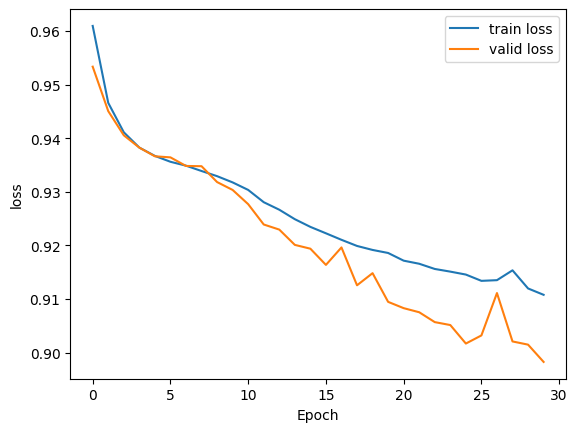

In [27]:
plt.plot(history.history['loss'], label='train loss')
plt.plot(history.history['val_loss'], label='valid loss')
plt.legend()
plt.xlabel('Epoch')
plt.ylabel('loss')
plt.show()

# Threshold

In [29]:
valid_x_predictions = model.predict(x_valid_scaled)
mse = np.mean(np.power(flatten(x_valid_scaled) - flatten(valid_x_predictions), 2), axis=1)

2217/2217 [==============================] - 28s 12ms/step


In [32]:
error_df = pd.DataFrame({'Reconstruction_error':mse, 
                         'True_class':list(y_valid)})
precision_rt, recall_rt, threshold_rt = metrics.precision_recall_curve(
    error_df['True_class'], error_df['Reconstruction_error'])

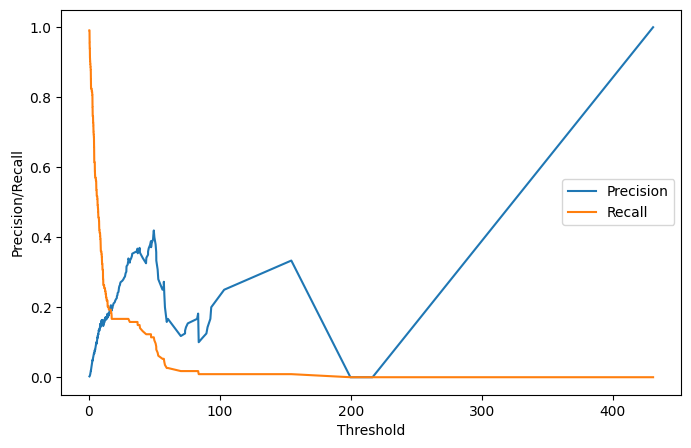

In [33]:
plt.figure(figsize=(8,5))
plt.plot(threshold_rt, precision_rt[1:], label='Precision')
plt.plot(threshold_rt, recall_rt[1:], label='Recall')
plt.xlabel('Threshold'); plt.ylabel('Precision/Recall')
plt.legend()
plt.show()

In [34]:
# best position of threshold
index_cnt = [cnt for cnt, (p, r) in enumerate(zip(precision_rt, recall_rt)) if p==r][0]
print('precision: ',precision_rt[index_cnt],', recall: ',recall_rt[index_cnt])

# fixed Threshold
threshold_fixed = threshold_rt[index_cnt]
print('threshold: ',threshold_fixed)

precision:  0.19298245614035087 , recall:  0.19298245614035087
threshold:  16.008583607189873


# Test

In [36]:
test_x_predictions = model.predict(x_test_scaled)

4433/4433 [==============================] - 46s 10ms/step


In [37]:
mse = np.mean(np.power(flatten(x_test_scaled) - flatten(test_x_predictions), 2), axis=1)

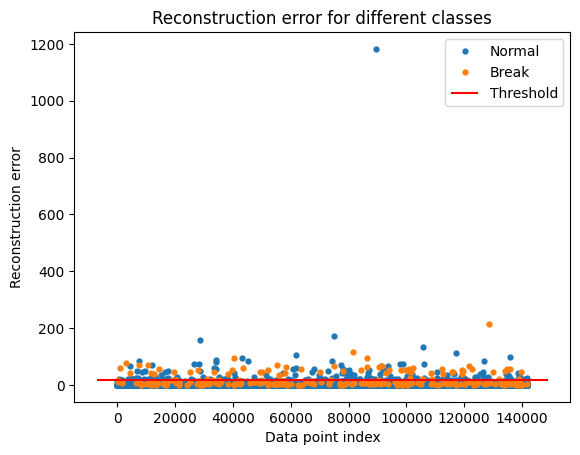

In [38]:
error_df = pd.DataFrame({'Reconstruction_error': mse,
                         'True_class': y_test.tolist()})

groups = error_df.groupby('True_class')
fig, ax = plt.subplots()

for name, group in groups:
    ax.plot(group.index, group.Reconstruction_error, marker='o', ms=3.5, linestyle='',
            label= "Break" if name == 1 else "Normal")
ax.hlines(threshold_fixed, ax.get_xlim()[0], ax.get_xlim()[1], colors="r", zorder=100, label='Threshold')
ax.legend()
plt.title("Reconstruction error for different classes")
plt.ylabel("Reconstruction error")
plt.xlabel("Data point index")
plt.show();

# Evaluation

In [39]:
from sklearn.metrics import confusion_matrix

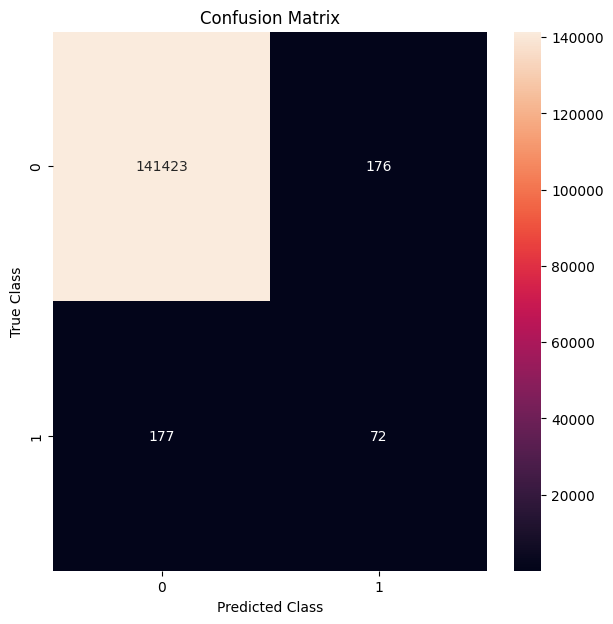

In [42]:
# classification by threshold
pred_y = [1 if e > threshold_fixed else 0 for e in error_df['Reconstruction_error'].values]

conf_matrix = metrics.confusion_matrix(error_df['True_class'], pred_y)
plt.figure(figsize=(7, 7))
sns.heatmap(conf_matrix, xticklabels=LABELS, yticklabels=LABELS, annot=True, fmt='d')
plt.title('Confusion Matrix')
plt.xlabel('Predicted Class'); plt.ylabel('True Class')
plt.show()